In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

In [2]:
import urllib.request

url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
zip_file_name = 'data/data.zip'
urllib.request.urlretrieve(url, zip_file_name)

('data/data.zip', <http.client.HTTPMessage at 0x135505d7520>)

# Preparing the dataset

In [36]:
df = pd.read_csv('data/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

For the rest of the homework, you'll need to use only these columns:

- age,
- job,
- marital,
- education,
- balance,
- housing,
- contact,
- day,
- month,
- duration,
- campaign,
- pdays,
- previous,
- poutcome,
- y

In [37]:
df = df.drop(columns= ['default', 'loan'])
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


## Split the data
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [38]:
from sklearn.model_selection import train_test_split

df.y = (df.y == 'yes').astype(int)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=len(df_test), random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values
y_full_train = df_full_train['y'].values

del df_train["y"]
del df_val["y"]
del df_test["y"]
del df_full_train['y']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [39]:
from sklearn.metrics import roc_auc_score

In [40]:
df_numeric_train = df_train.select_dtypes(include=['number'])
df_numeric_train.head()

,age,balance,day,duration,campaign,pdays,previous
0,33,4790,20,137,1,272,2
1,32,392,21,148,2,-1,0
2,40,2129,30,452,1,-1,0
3,54,1180,19,394,2,-1,0
4,57,97,16,260,6,-1,0


In [41]:
auc_scores = []
for col in df_numeric_train.columns:
    auc = roc_auc_score(y_train, df_train[col])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    auc_scores.append({'Column': col, 'AUC': auc})

df_numeric_auc_scores = pd.DataFrame(auc_scores)
df_numeric_auc_scores

,Column,AUC
0,age,0.512172
1,balance,0.588820
2,day,0.525965
3,duration,0.814694
4,campaign,0.571453
5,pdays,0.590124
6,previous,0.598562


In [42]:
from sklearn.metrics import roc_curve

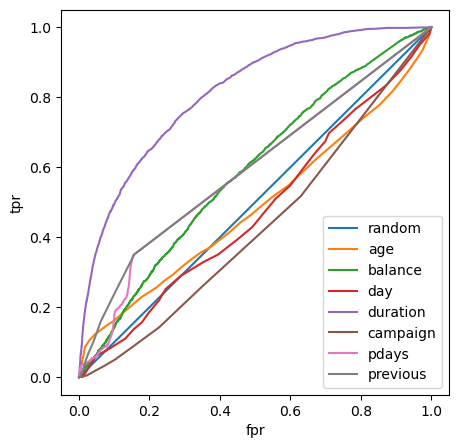

In [43]:
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], label='random')
for col in df_numeric_train.columns:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[col])
    
    plt.plot(fpr, tpr, label=col)
    
    
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [53]:
from sklearn.feature_extraction import DictVectorizer

In [54]:
dv = DictVectorizer(sparse=False)

In [55]:
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [56]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]

In [60]:
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.9

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [81]:
thresholds = np.linspace(0,1,101)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t,tp,fp,fn,tn))
cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = cols)
df_scores['precision'] = df_scores.tp/(df_scores.tp+df_scores.fp)
df_scores['recall'] = df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7945,0,0,0.121420,1.000000
1,0.01,1094,6965,4,980,0.135749,0.996357
2,0.02,1093,5762,5,2183,0.159446,0.995446
3,0.03,1087,4727,11,3218,0.186963,0.989982
4,0.04,1064,3804,34,4141,0.218570,0.969035


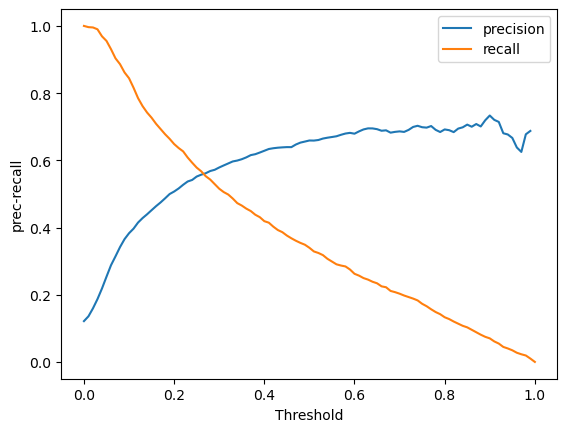

In [82]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.xlabel('Threshold')
plt.ylabel('prec-recall')
plt.legend()

In [67]:
df_scores[:33]

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7945,0,0,0.121420,1.000000
1,0.01,1094,6965,4,980,0.135749,0.996357
2,0.02,1093,5762,5,2183,0.159446,0.995446
3,0.03,1087,4727,11,3218,0.186963,0.989982
4,0.04,1064,3804,34,4141,0.218570,0.969035
5,0.05,1049,3087,49,4858,0.253627,0.955373
6,0.06,1022,2529,76,5416,0.287806,0.930783
7,0.07,992,2164,106,5781,0.314322,0.903461
8,0.08,973,1874,125,6071,0.341763,0.886157
9,0.09,946,1643,152,6302,0.365392,0.861566


In [79]:
thresholds = np.linspace(0,1,1001)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t,tp,fp,fn,tn))
cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = cols)
df_scores['precision'] = df_scores.tp/(df_scores.tp+df_scores.fp)
df_scores['recall'] = df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall
0,0.000,1098,7945,0,0,0.121420,1.000000
1,0.001,1098,7934,0,11,0.121568,1.000000
2,0.002,1098,7912,0,33,0.121865,1.000000
3,0.003,1098,7876,0,69,0.122353,1.000000
4,0.004,1097,7797,1,148,0.123342,0.999089


In [80]:
df_scores[df_scores.precision == df_scores.recall]

,threshold,tp,fp,fn,tn,precision,recall
266,0.266,614,484,484,7461,0.559199,0.559199


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [84]:
df_scores['F1'] = (2 * df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall)

In [95]:
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.00,1098,7945,0,0,0.121420,1.000000,0.216547
1,0.01,1094,6965,4,980,0.135749,0.996357,0.238943
2,0.02,1093,5762,5,2183,0.159446,0.995446,0.274865
3,0.03,1087,4727,11,3218,0.186963,0.989982,0.314525
4,0.04,1064,3804,34,4141,0.218570,0.969035,0.356688


In [96]:
df_scores.sort_values(by='F1', ascending=False).iloc[0]["threshold"]

0.22

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [97]:
from sklearn.model_selection import KFold

In [104]:
def train_reg(df_train,y_train, c = 1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear',C = c, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df,dv,model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [105]:
n_splits = 5
scores = []
kfold = KFold(n_splits=n_splits, random_state=1, shuffle=True)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_split = df_full_train.iloc[train_idx]
    df_val_split = df_full_train.iloc[val_idx]
    
    y_train_split = y_full_train[train_idx]
    y_val_split = y_full_train[val_idx]
    
    dv, model = train_reg(df_train_split,y_train_split, 1)
    y_pred_split = predict(df_val_split, dv, model)
    
    auc = roc_auc_score(y_val_split, y_pred_split)
    scores.append(auc)
print('%.3f  %.3f' % (np.mean(scores), np.std(scores)))

0.906  0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [106]:
from tqdm.auto import tqdm

In [107]:
n_splits = 5
for c in tqdm([0.000001, 0.001, 1]):
    scores = []
    kfold = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_split = df_full_train.iloc[train_idx]
        df_val_split = df_full_train.iloc[val_idx]
        
        y_train_split = y_full_train[train_idx]
        y_val_split = y_full_train[val_idx]
        
        dv, model = train_reg(df_train_split,y_train_split, c)
        y_pred_split = predict(df_val_split, dv, model)
        
        auc = roc_auc_score(y_val_split, y_pred_split)
        scores.append(auc)
    print('%s %.3f  %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

1e-06 0.701  0.009
0.001 0.861  0.007
1 0.906  0.006
